## Denoise noisy sinogram to filter sinogram, then backproject to obtain reconstruction, no training data!

With our measured sinogram $\mathbf{m}$, we denoise with a CNN and then backproject to get to our direct, FBP image $\hat{\mathbf{x}}$. We train the CNN by minimizing the MSE loss between the forward projection of the FBP image $\mathbf{A}\hat{\mathbf{x}}$ and $\mathbf{m}$.

In [1]:
from skimage.data import brain
import numpy as np
import torch, torch.nn as nn
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:


nxd = 128
nphi = int(nxd*1.42)
nrd = int(nxd*1.42)

brain = brain()
true_object = resize(brain[5,30:-1, :-30], (nxd, nxd), anti_aliasing=False)


def fp_system(image, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat, torch.reshape(image, (nxd*nxd, 1))), (nphi, nrd))

def bp_system(sino, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat.T, torch.reshape(sino, (nrd * nphi, 1))), (nxd, nxd))

def np_to_torch(in_np):
    return torch.from_numpy(in_np).float().unsqueeze(0).unsqueeze(0)

def torch_to_np(in_torch):
    return np.squeeze(in_torch.detach().cpu().numpy())

true_object_tensor = np_to_torch(true_object)

In [3]:
#create system model A as a matrix.
#nxd, numbe rof samples in image
#specify the number of radial samples on the sinogram that we are projecting to
# how many projection angles there are
def make_system_matrix(nxd, nrd, nphi):
    system_matrix = torch.zeros(nrd * nphi, nxd * nxd) # rows = num sinobins, #column = num image pixels
    # each column correpsonds to the entire sinogram of a given pixel
    # each row of A corresponds to a sensitvity iamge for each sinogram bin!, 
    #   a straight white line through the pixel in the image-space!
    # forward projection is in the sinogram space
    for xv in range(nxd):
        for yv in range(nxd): #selected pizel (xv, yv)
            for ph in range(nphi): #now for each angle, project that pixel
                yp = -(xv - (nxd * 0.5)) * np.sin(ph * np.pi/ nphi) + (yv - (nxd * 0.5)) * np.cos(ph * np.pi / nphi) #center to the pixel
                yp_bin = int(yp + nrd/ 2.0)
                system_matrix[yp_bin + ph * nrd, xv + yv *nxd] = 1.0
    return system_matrix

Text(0.5, 1.0, 'true')

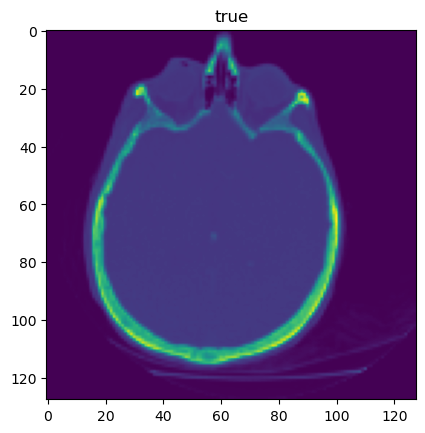

In [4]:
plt.imshow(true_object)
plt.title("true")

## View our forward projected, measured sinogram $\mathbf{m}$

cpu


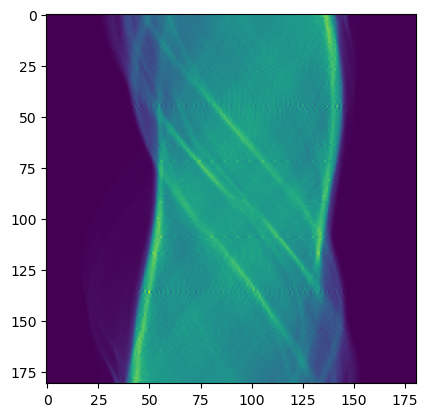

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
out = make_system_matrix(nxd, nrd, nphi)
#sysmat = make_system_matrix(nxd, nrd, nphi).to(device)

true_sinogram = fp_system(true_object_tensor, out, nxd, nrd, nphi) #a tensor

plt.imshow(torch_to_np(true_sinogram))

## Make our CNN

number of channels determines the numbers of kernels used which determine how many output channels/feature maps output from that layer.

In [6]:
class NEW_CNN(nn.Module):
    def __init__(self, num_channels):
        super(NEW_CNN, self).__init__()
        self.CNN = nn.Sequential(
            #1 input image, 8 channels(output images), 7x7 kernels, zero padding
            nn.Conv2d(1, num_channels, 3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, num_channels,3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(), 
            nn.Conv2d(num_channels, 1, 3, padding = (1,1), padding_mode = 'reflect'), nn.PReLU(),
        )
    def forward(self, x):
        x = torch.squeeze(self.CNN(x.unsqueeze(0).unsqueeze(0)))
        return x
cnn = NEW_CNN(32).to(device)

class FBP_CNN_NET(nn.Module):
    def __init__(self, cnn, sino_for_reconstruction):
        super(FBP_CNN_NET, self).__init__()
        self.sino_ones = torch.ones_like(sino_for_reconstruction)
        self.sens_image = bp_system(self.sino_ones, out, nxd, nrd, nphi)
        self.cnn = cnn
        self.prelu = nn.PReLU()

    def forward(self, sino_for_reconstruction):
        recon = torch.ones(nxd, nxd).to(device)
        #going to iterate to update recon, then use cnn to 
        filtered_sino = self.cnn(sino_for_reconstruction)
        recon = bp_system(filtered_sino, out, nxd, nrd, nphi) / (self.sens_image +1.0e-15)          
        recon = self.prelu(recon)
        fpsino = fp_system(recon, out, nxd, nrd, nphi)

        return recon, fpsino



In [7]:
true_sino_torch = true_sinogram

fbp_cnn = FBP_CNN_NET(cnn, true_sino_torch).to(device)
#mlem_cnn = fbp_cnn(true_sinogram)

loss_fun = nn.MSELoss()
optimiser = torch.optim.Adam(fbp_cnn.parameters(), lr = 0.0001)

train_loss = list()
epochs = 1000
for ep in range(epochs):
    fbp_recon, rec_fp = fbp_cnn(true_sino_torch)
    loss = loss_fun(rec_fp, torch.squeeze(true_sino_torch))
    train_loss.append(loss.item())
    loss.backward() # find the gradients
    optimiser.step() # does the update
    optimiser.zero_grad() #set gradients to zero
    if ep % 10 == 0:
        print('epoch %d training loss = %f' % (ep, train_loss[-1]))

epoch 0 training loss = 53.793839
epoch 10 training loss = 22.821800
epoch 20 training loss = 14.286034
epoch 30 training loss = 11.550233
epoch 40 training loss = 10.853450
epoch 50 training loss = 10.660125
epoch 60 training loss = 10.322430
epoch 70 training loss = 9.832143
epoch 80 training loss = 9.110500
epoch 90 training loss = 7.950317
epoch 100 training loss = 6.833467
epoch 110 training loss = 5.020710
epoch 120 training loss = 3.801064
epoch 130 training loss = 3.660141
epoch 140 training loss = 3.605138
epoch 150 training loss = 3.567338
epoch 160 training loss = 3.557868
epoch 170 training loss = 3.544727
epoch 180 training loss = 3.538000
epoch 190 training loss = 3.531385
epoch 200 training loss = 3.525956
epoch 210 training loss = 3.520936
epoch 220 training loss = 3.516022
epoch 230 training loss = 3.511124
epoch 240 training loss = 3.506025
epoch 250 training loss = 3.500069
epoch 260 training loss = 3.488947
epoch 270 training loss = 3.481972
epoch 280 training loss 

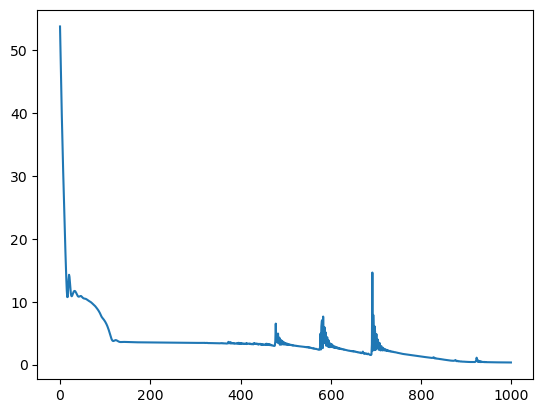

In [8]:
plt.plot(np.arange(epochs), np.array(train_loss))

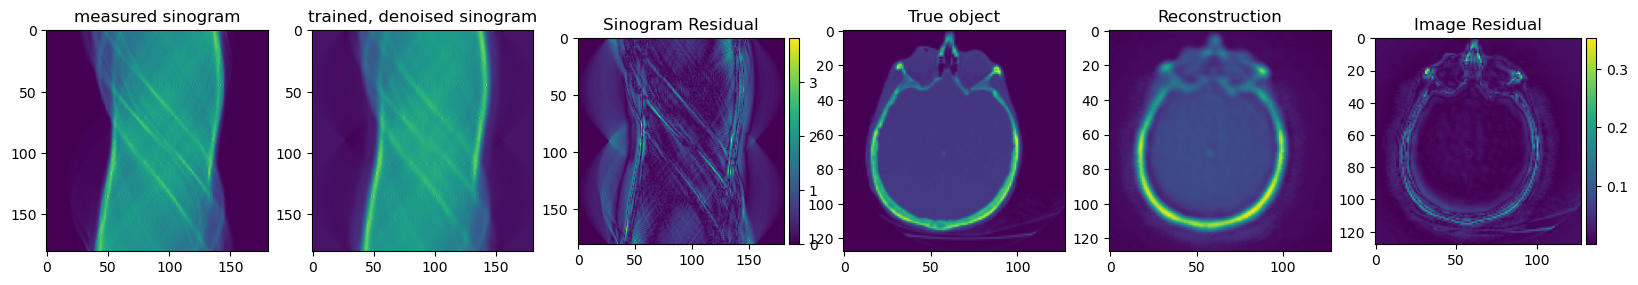

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1,6, figsize = (20, 10))
np_object = torch_to_np(true_object_tensor)
fbp_recon_plot = torch_to_np(fbp_recon)

ax[0].imshow(torch_to_np(true_sinogram))
ax[0].set_title("measured sinogram")

ax[1].imshow(torch_to_np(rec_fp))
ax[1].set_title("trained, denoised sinogram")

divider = make_axes_locatable(ax[2])
difference = ax[2].imshow(np.abs(torch_to_np(true_sinogram) - torch_to_np(rec_fp)))
ax[2].set_title("Sinogram Residual")

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(difference, cax = cax)


ax[3].imshow(np_object)
ax[3].set_title("True object")

ax[4].imshow(fbp_recon_plot)
ax[4].set_title("Reconstruction")


divider = make_axes_locatable(ax[5])
difference = ax[5].imshow(np.abs(np_object - fbp_recon_plot))
ax[5].set_title("Image Residual")

divider = make_axes_locatable(ax[5])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(difference, cax = cax)
